In [21]:
import matplotlib.pyplot as ptt
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [22]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

2.1.2
4.5.0
0.5.2
1.5.2


## packages load

In [23]:
import warnings
warnings.filterwarnings("ignore")  # Suppress general warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings

# OS and path handling
import os
from os.path import join


# Data manipulation and visualization
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import missingno as msno  # For visualizing missing data
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For enhanced data visualization

# Machine learning models and tools
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor  # Ensemble models
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV  # Model selection and evaluation
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.feature_selection import SelectKBest, f_regression # For feature selection
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.metrics import mean_squared_error  #For regression evaluation


# Specialized libraries for gradient boosting
import xgboost as xgb # XGBoost library
import lightgbm as lgb # LightGBM library
from xgboost import XGBRegressor # XGBoost Regressor
from lightgbm import LGBMRegressor # LightGBM Regressor



from scipy.stats import randint, uniform # For defining distributions in hyperparameter tuning


In [43]:
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 파일 경로 설정


In [25]:
train_data_path = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/train.csv'
sub_data_path = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/test.csv'
sub_file_path = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/sample_submission.csv'

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [26]:
# Load the datasets

data = pd.read_csv(train_data_path, index_col = 'id')
# data['date'] = pd.to_datetime(data['date'])


#date 변수는 연월일시간으로 값을 가지고 있는데, int 변수로 만들겠습니다.
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)



# Checking structure and initial rows of the training data
display(data.head()) # Display first few rows
print(data.info()) # Structure and data types

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                         
0   201410  221900.0         3       1.00         1180      5650     1.0   
1   201502  180000.0         2       1.00          770     10000     1.0   
2   201502  510000.0         3       2.00         1680      8080     1.0   
3   201406  257500.0         3       2.25         1715      6819     2.0   
4   201501  291850.0         3       1.50         1060      9711     1.0   

    waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
id                                                                            
0            0     0          3      7        1180              0      1955   
1            0     0          3      6         770              0      1933   
2            0     0          3      8        1680              0      1987   
3            0     0          3      7        1715              0      1995   
4            0     0          3      7        1060              0      1963   

    yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
id                                                                      
0              0    98178  47.5112 -122.257           1340        5650  
1              0    98028  47.7379 -122.233           2720        8062  
2              0    98074  47.6168 -122.045           1800        7503  
3              0    98003  47.3097 -122.327           2238        6819  
4              0    98198  47.4095 -122.315           1650        9711

<class 'pandas.core.frame.DataFrame'>
Index: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   price          15035 non-null  float64
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_living

In [27]:
print(data['date'].min(), data['date'].max())

201405 201505


## 2. 간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

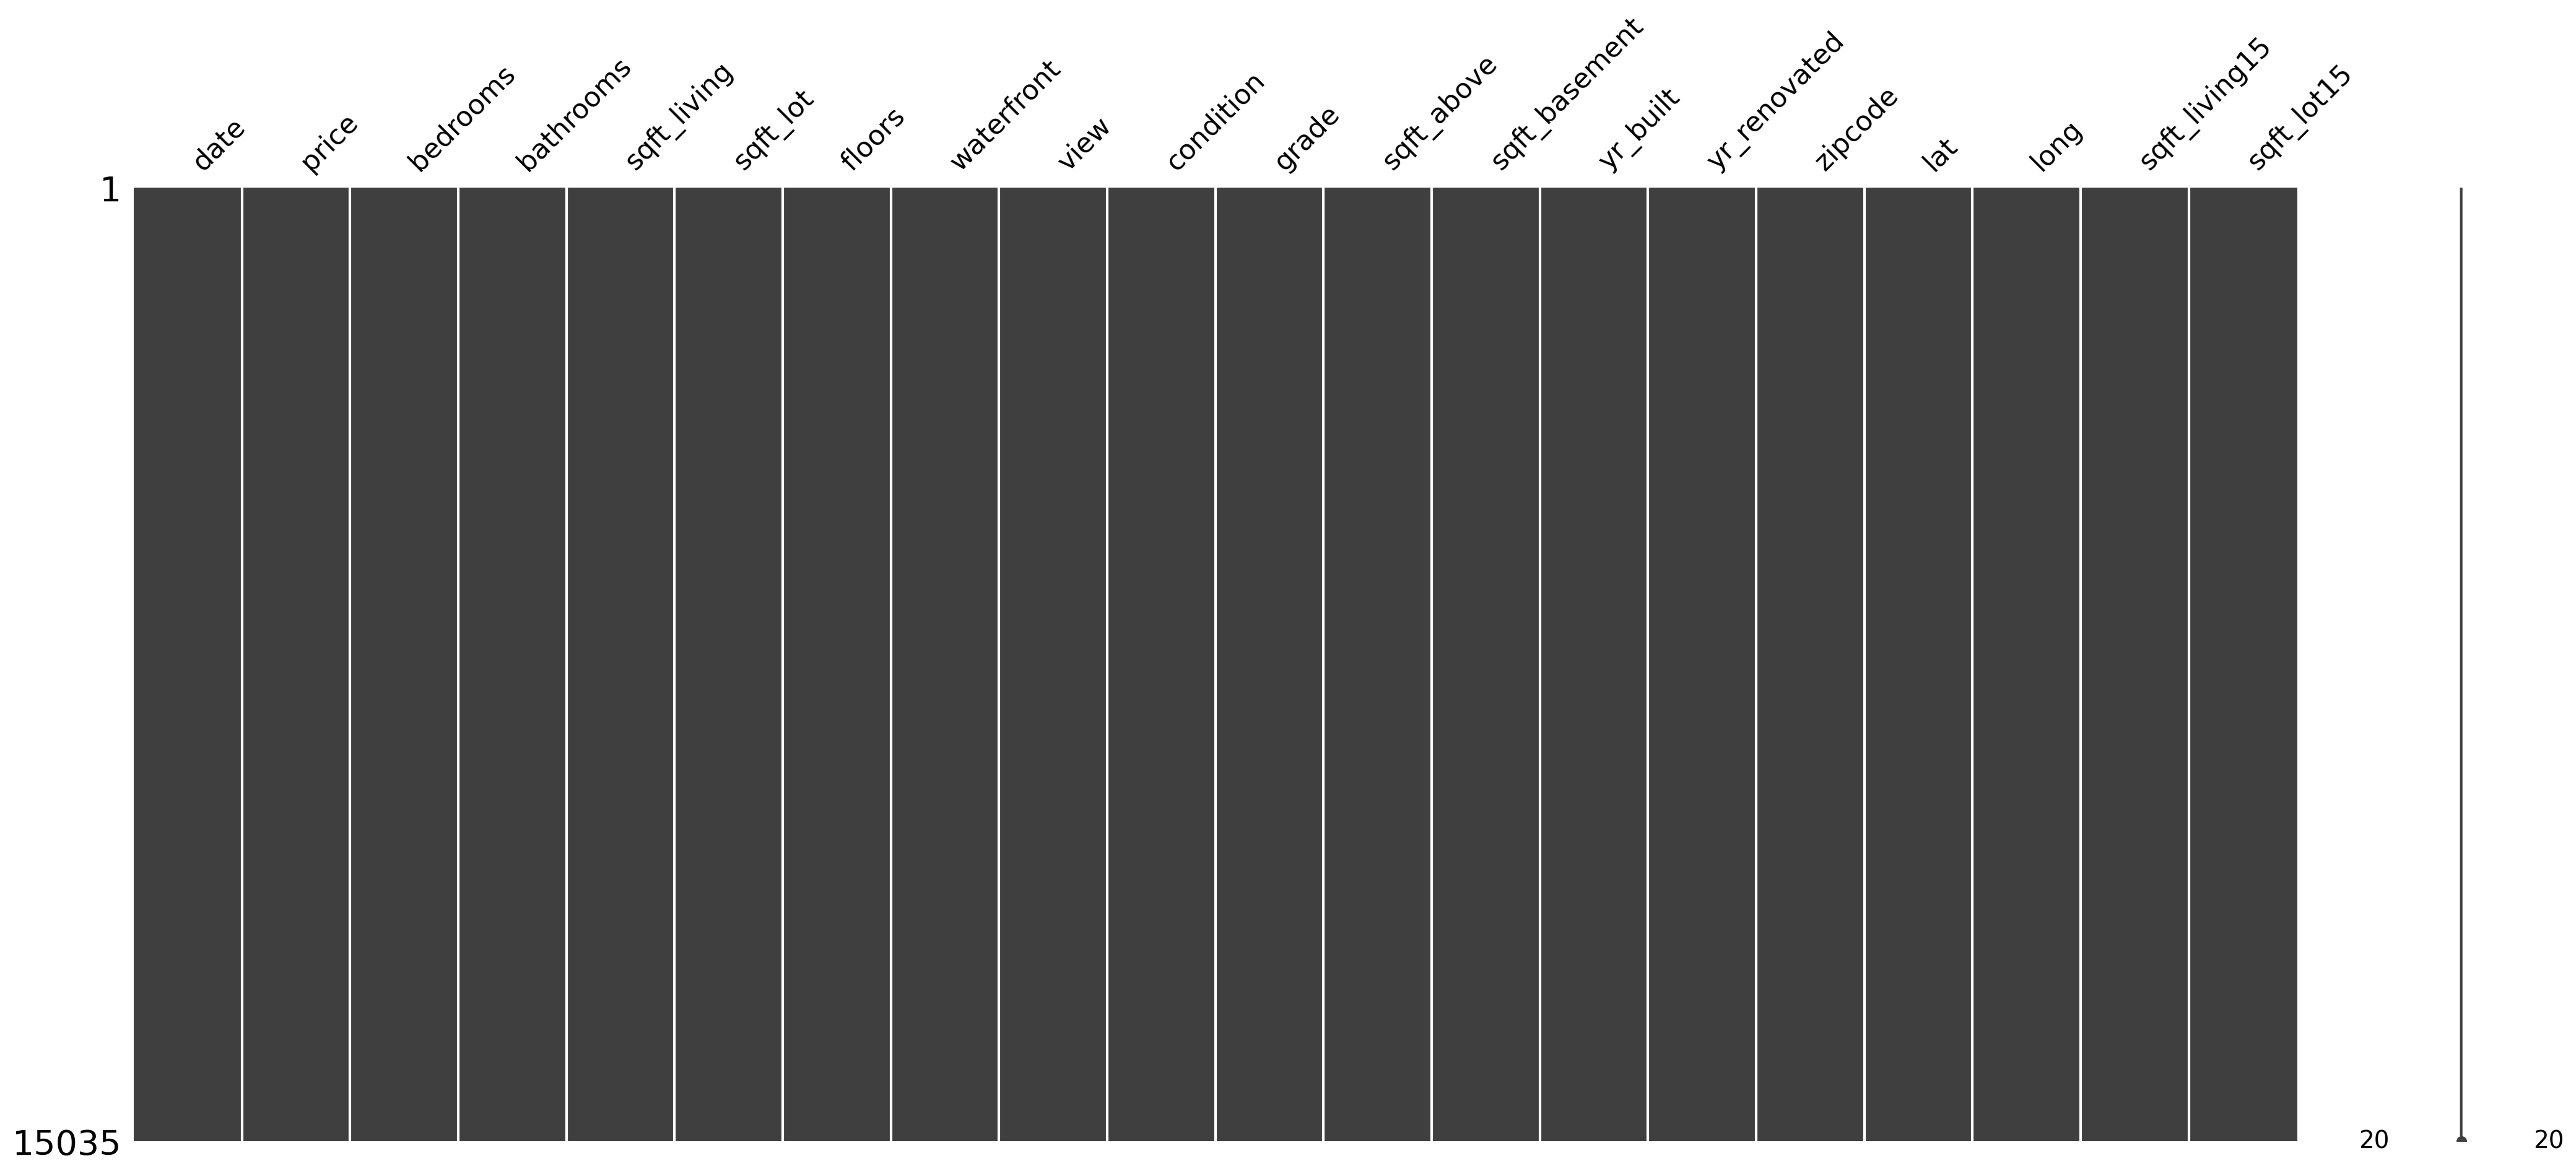

In [28]:
msno.matrix(data)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

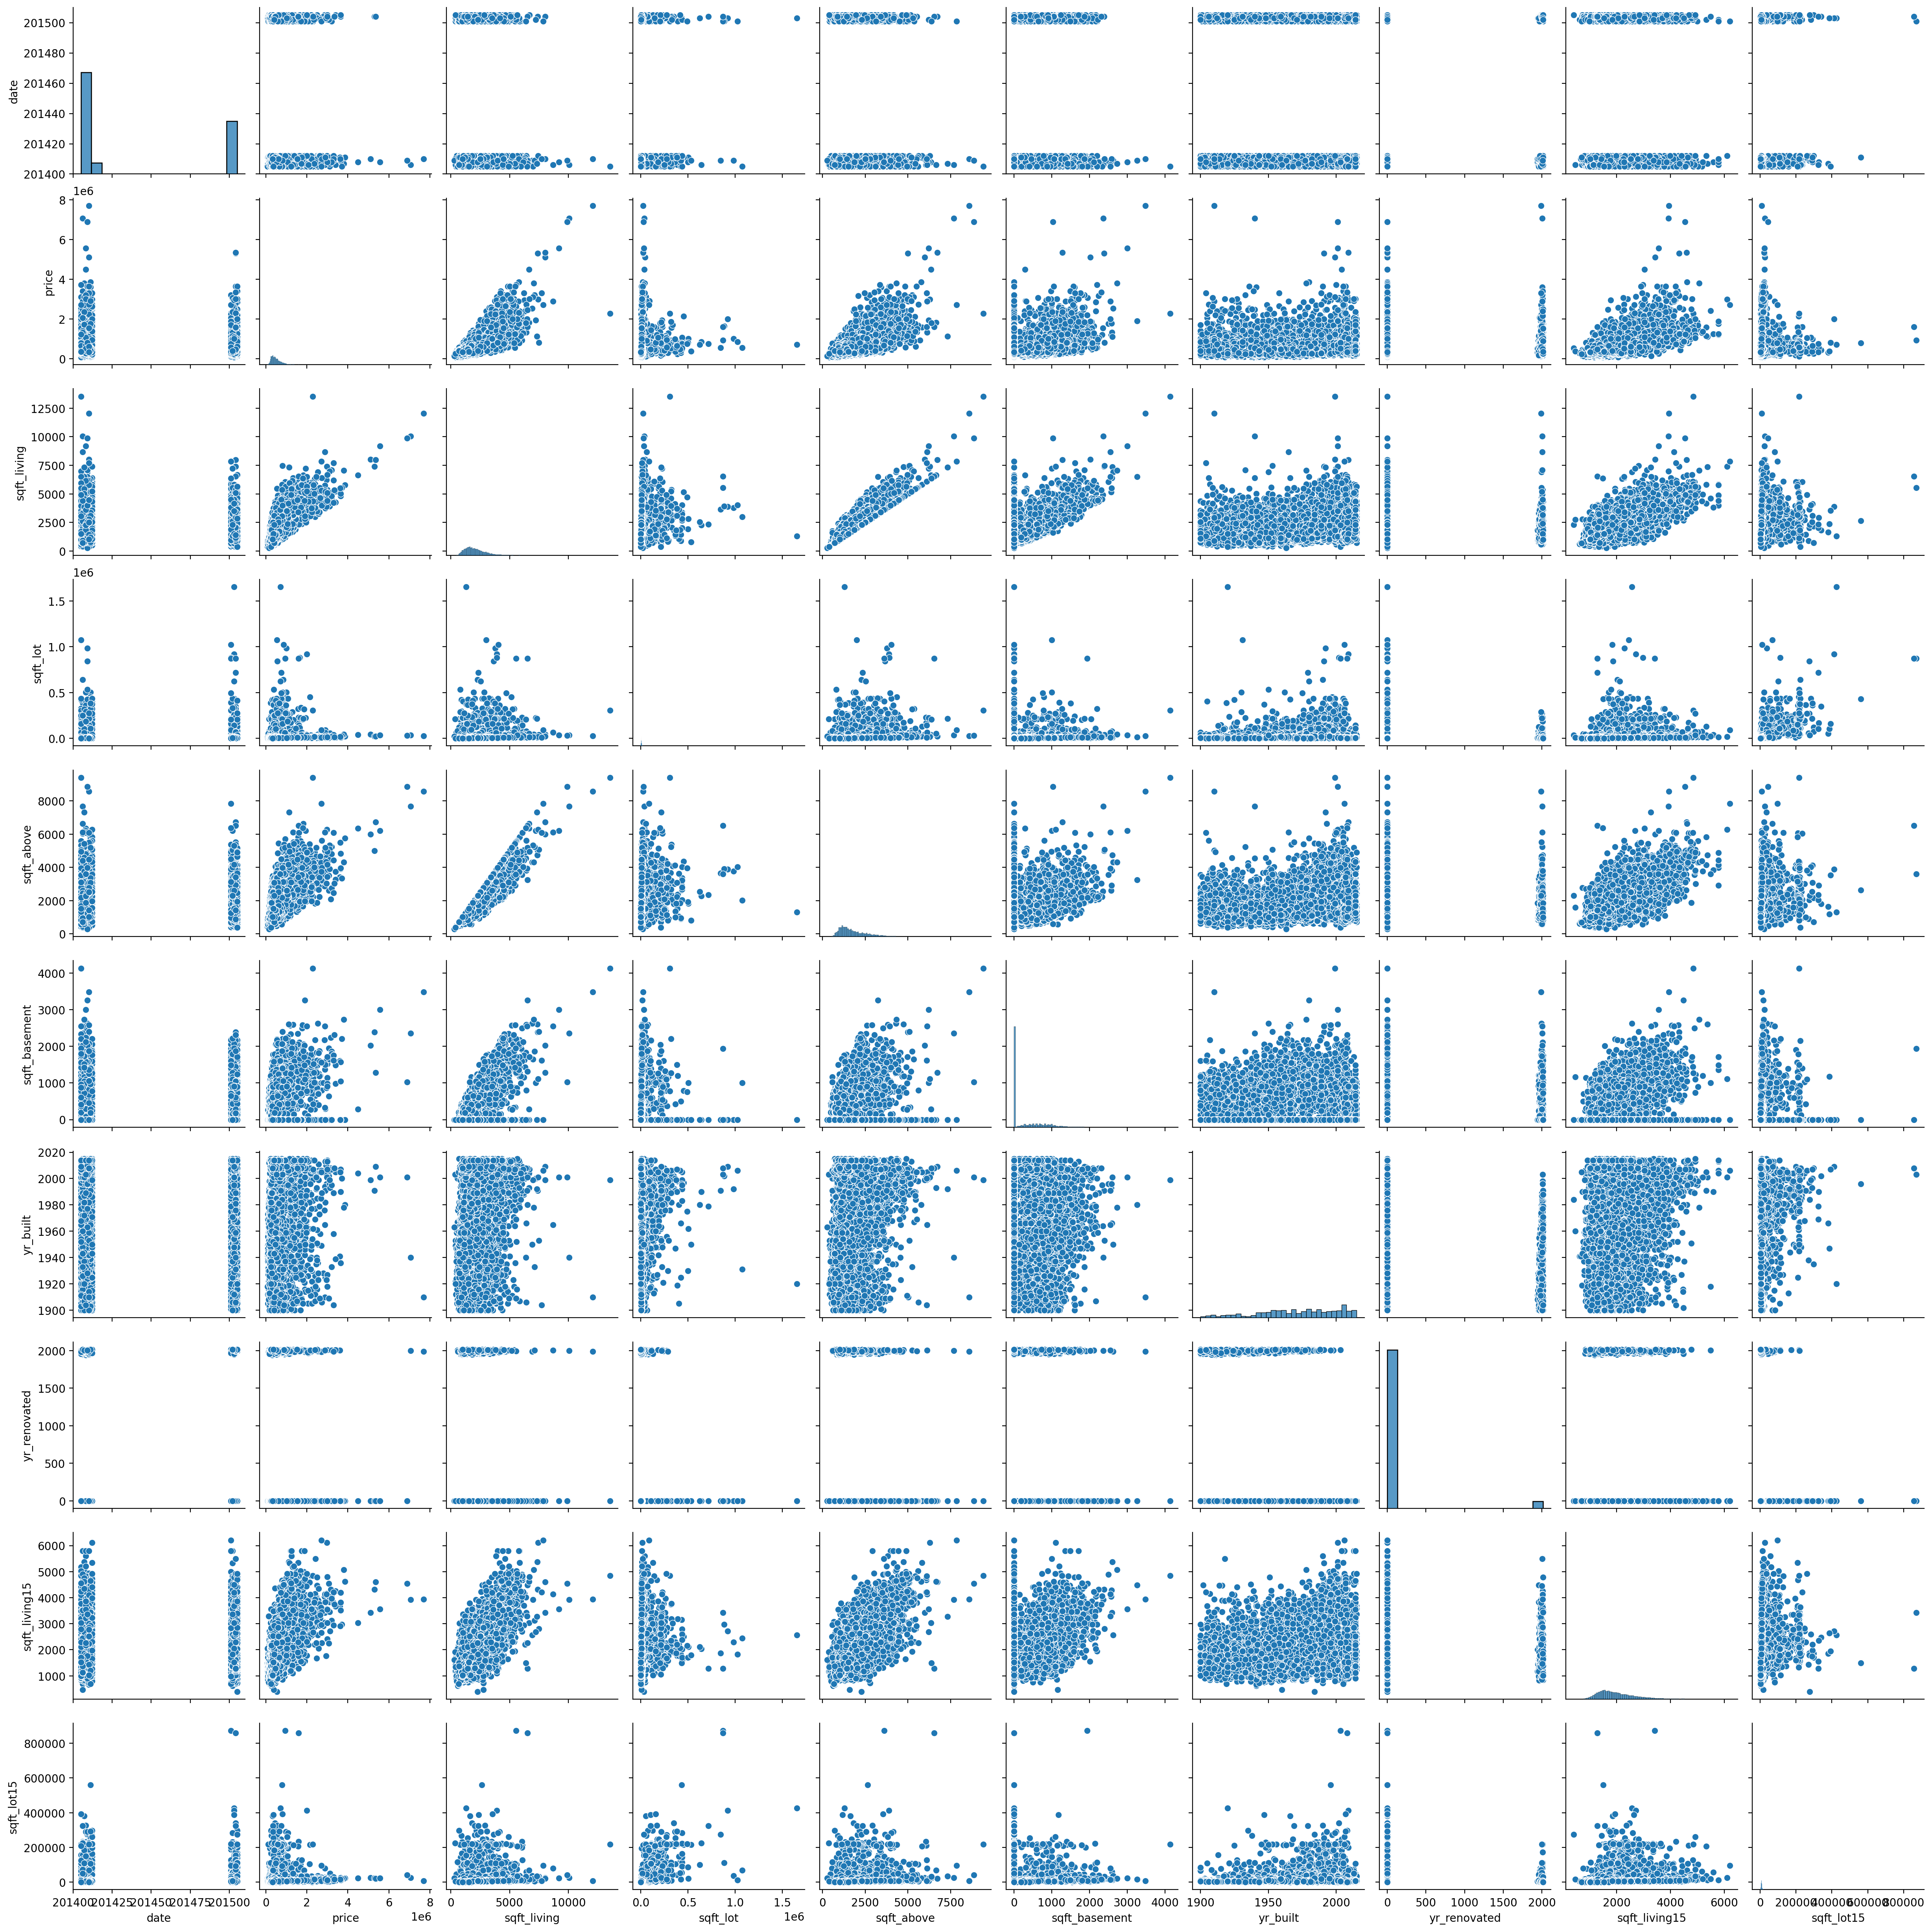

In [29]:
scatter_cols = [
    'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
    'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15'
]
sns.pairplot(data[scatter_cols])
plt.show()

In [30]:
print(data['yr_renovated'].describe())

count    15035.000000
mean        83.798936
std        400.398498
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64


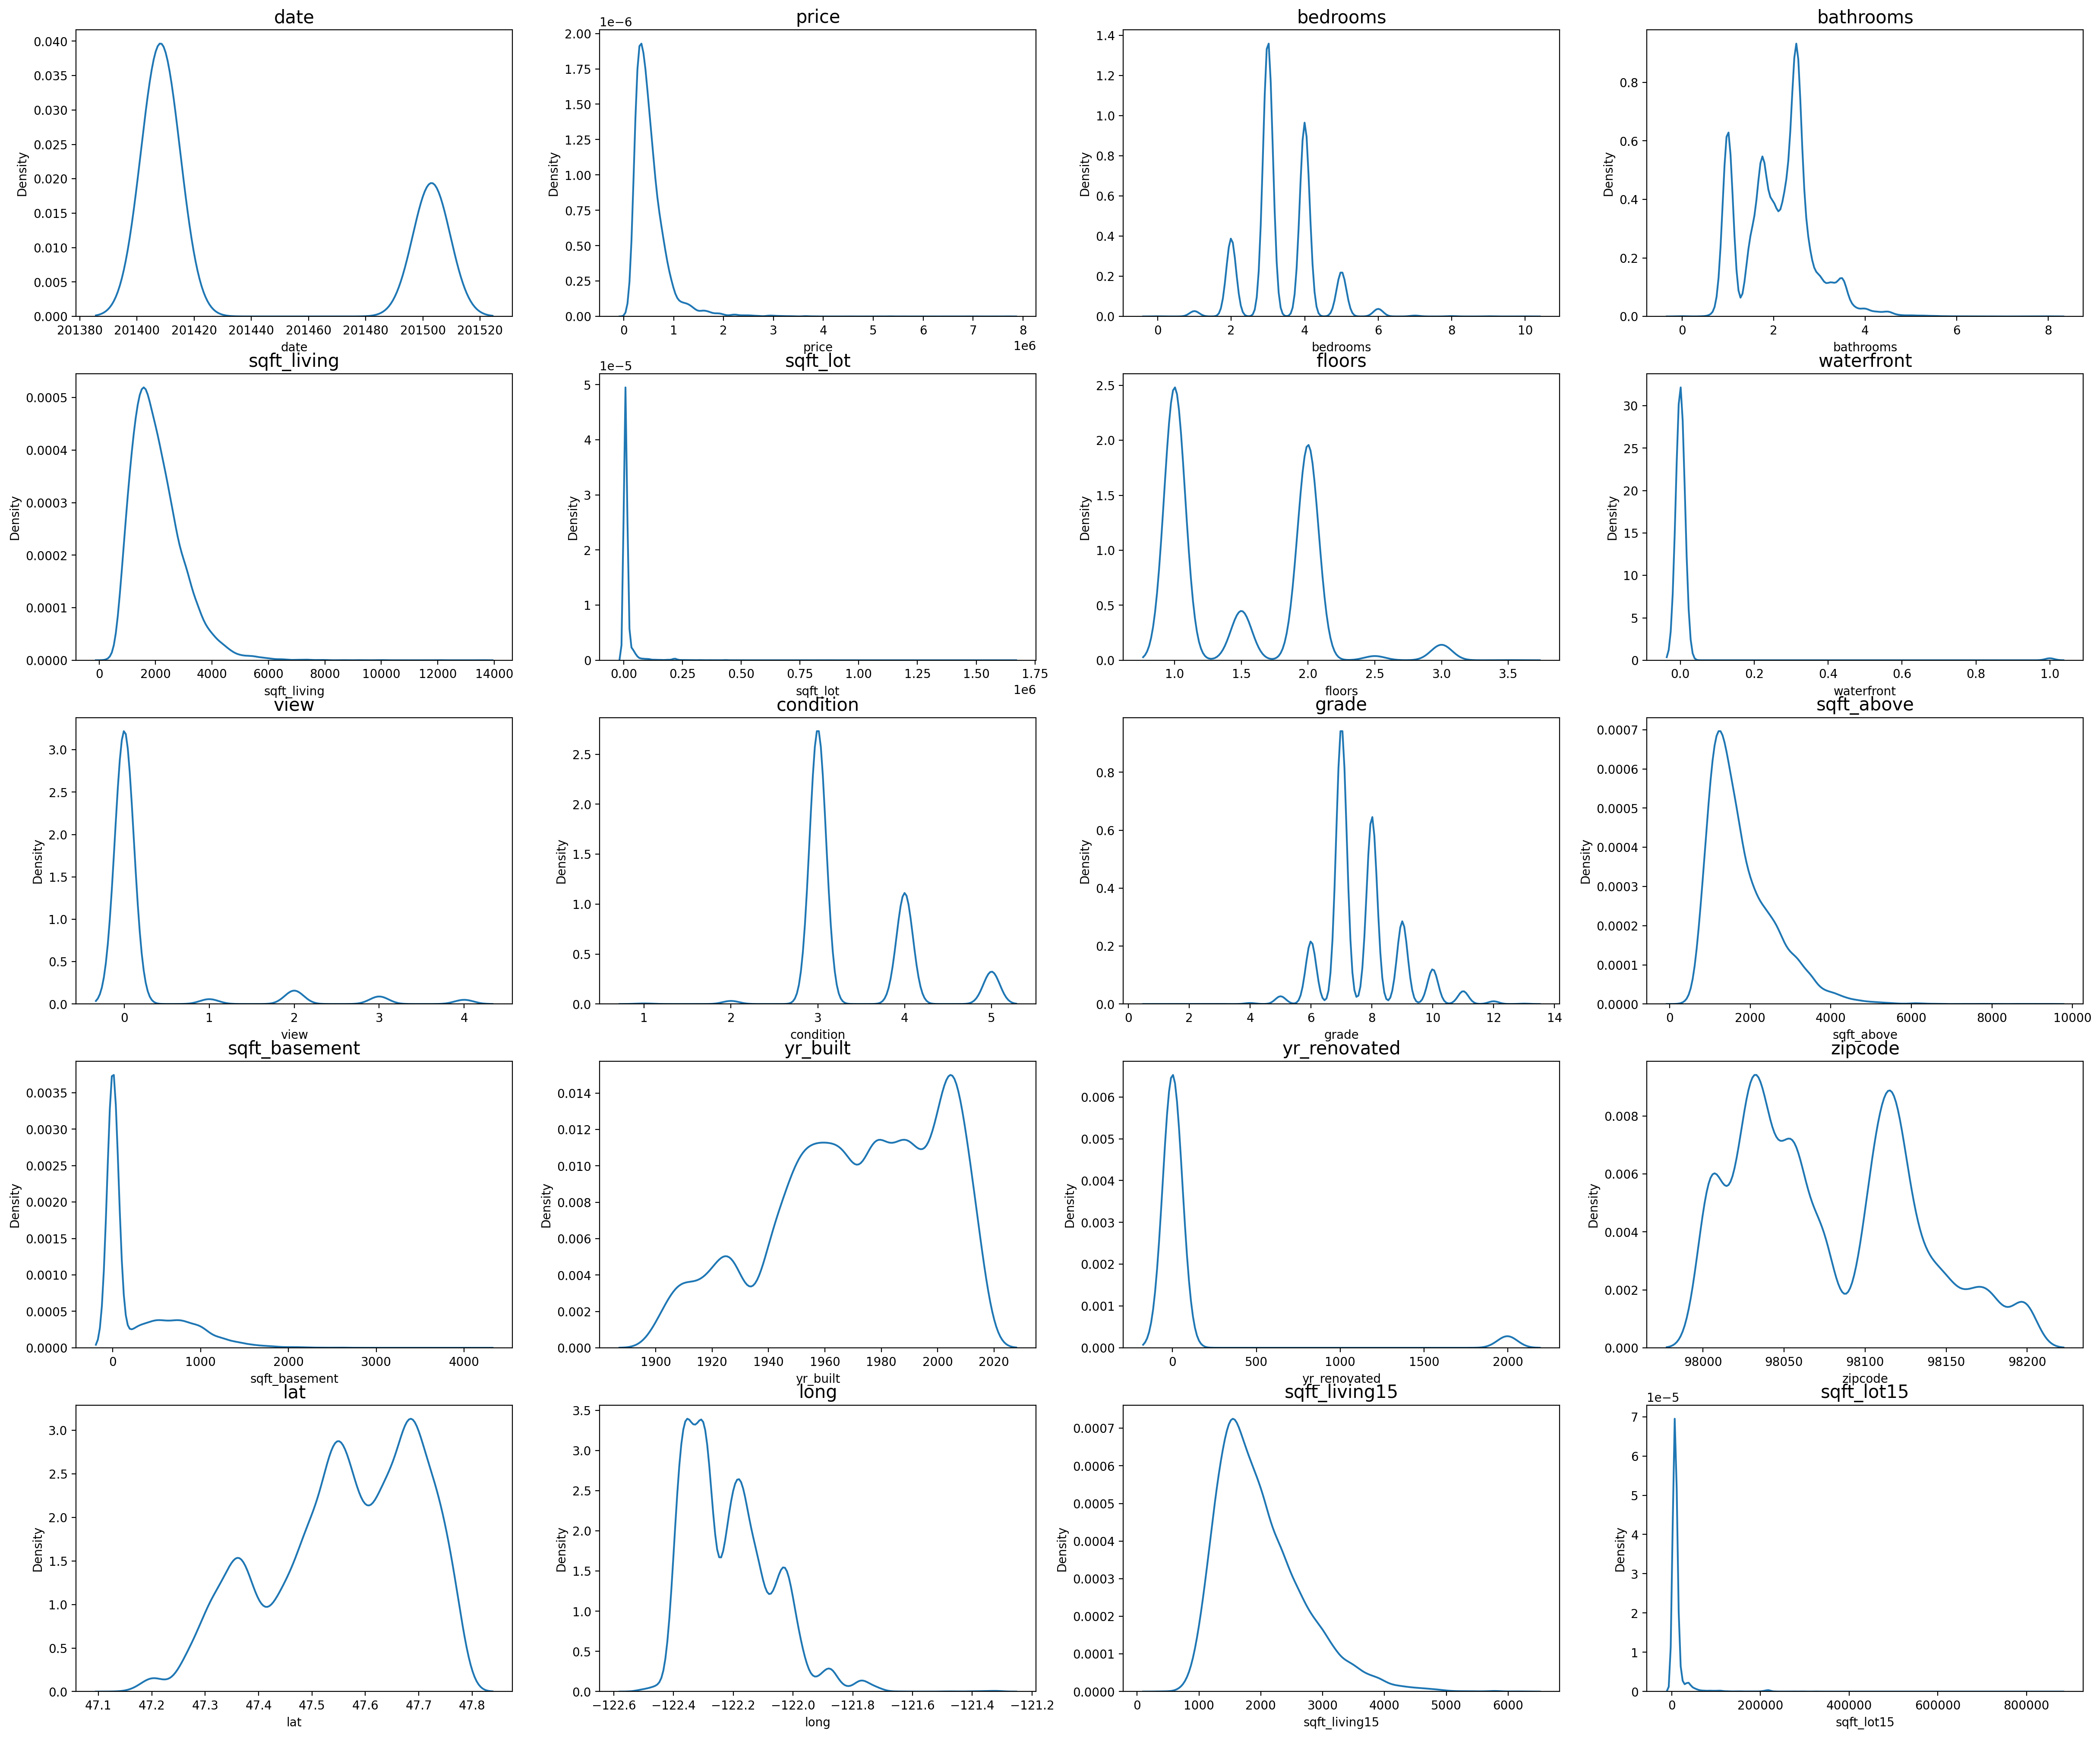

In [31]:
fig, ax = plt.subplots(5, 4, figsize = (30, 25))

columns = data.columns
count = 0
for row in range(5):
    for col in range(4):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
plt.show()

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

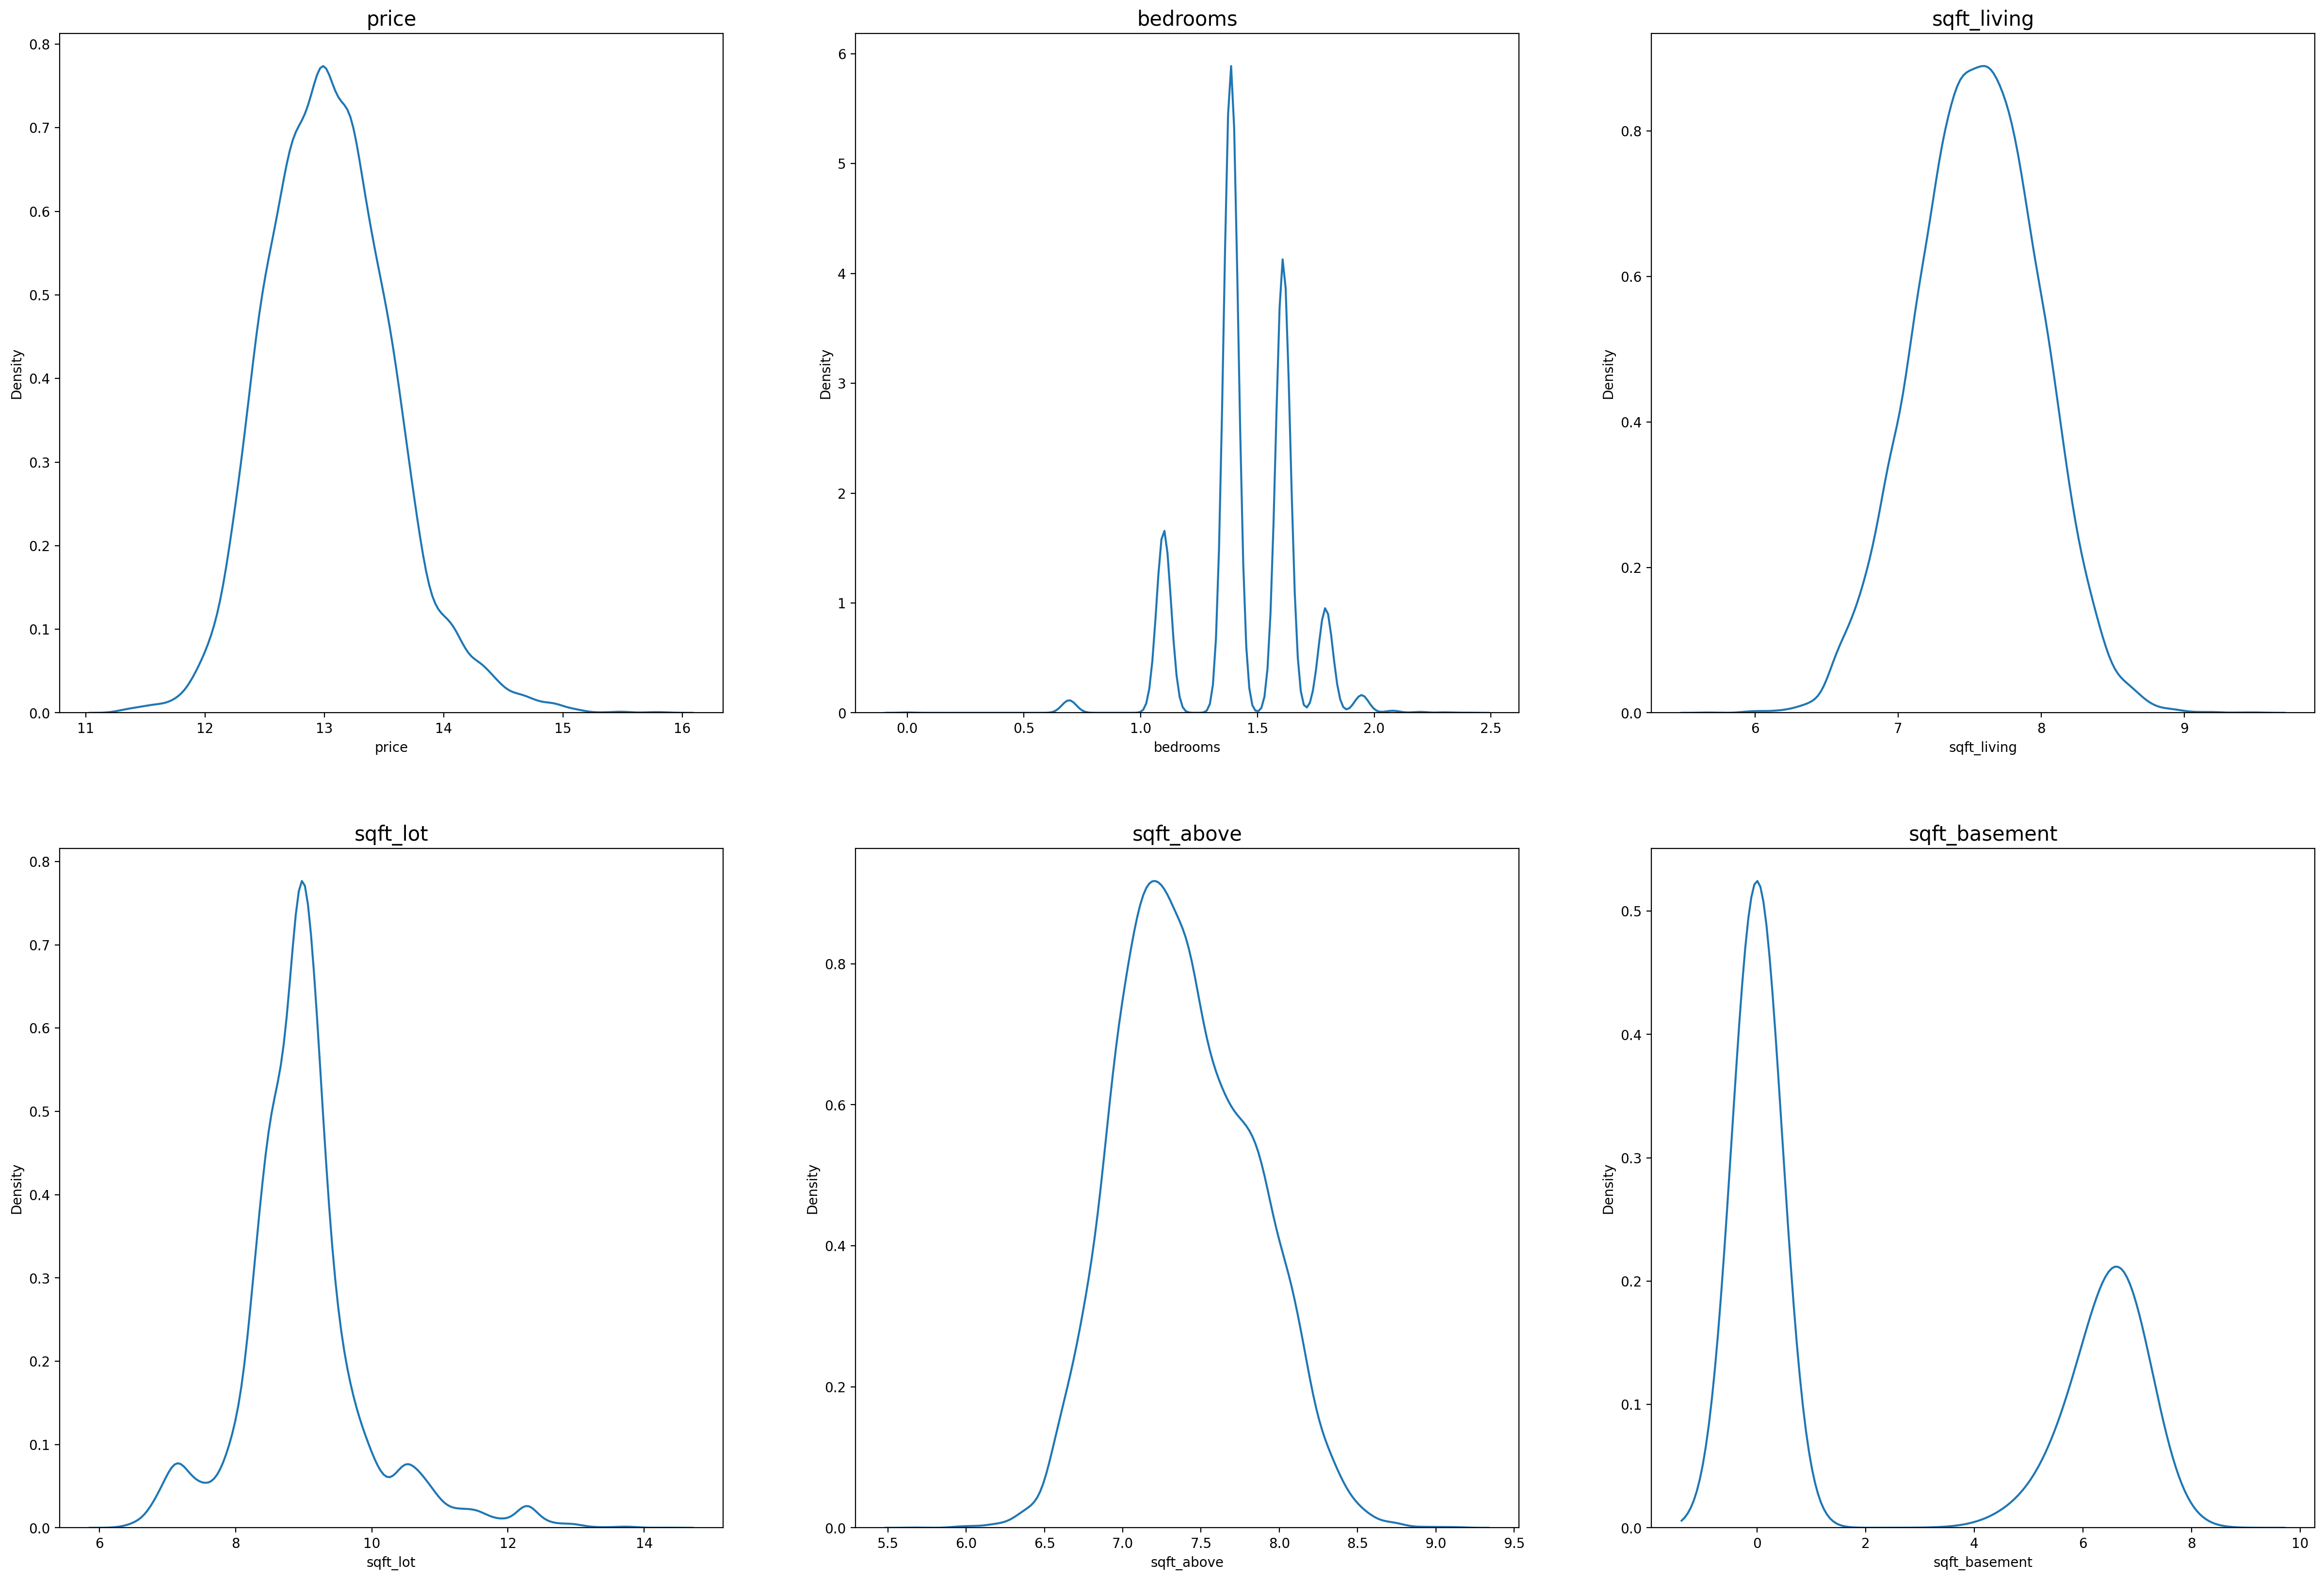

In [32]:
skew_columns = ['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(2, 3, figsize = (30, 20))

count = 0
for row in range(2):
    for col in range(3):
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
plt.show()

In [33]:
print(data.describe())

                date         price      bedrooms     bathrooms   sqft_living  \
count   15035.000000  15035.000000  15035.000000  15035.000000  15035.000000   
mean   201438.545993     13.048122      1.452912      2.115065      7.552362   
std        44.252050      0.527471      0.210784      0.767519      0.425656   
min    201405.000000     11.264477      0.000000      0.000000      5.673323   
25%    201407.000000     12.682310      1.386294      1.750000      7.266129   
50%    201410.000000     13.017005      1.386294      2.250000      7.555382   
75%    201502.000000     13.377007      1.609438      2.500000      7.848153   
max    201505.000000     15.856731      2.397895      8.000000      9.513477   

           sqft_lot        floors    waterfront          view     condition  \
count  15035.000000  15035.000000  15035.000000  15035.000000  15035.000000   
mean       8.992803      1.498071      0.007117      0.234253      3.406651   
std        0.905809      0.538522      0.0

## 변수간 상관관계 분석


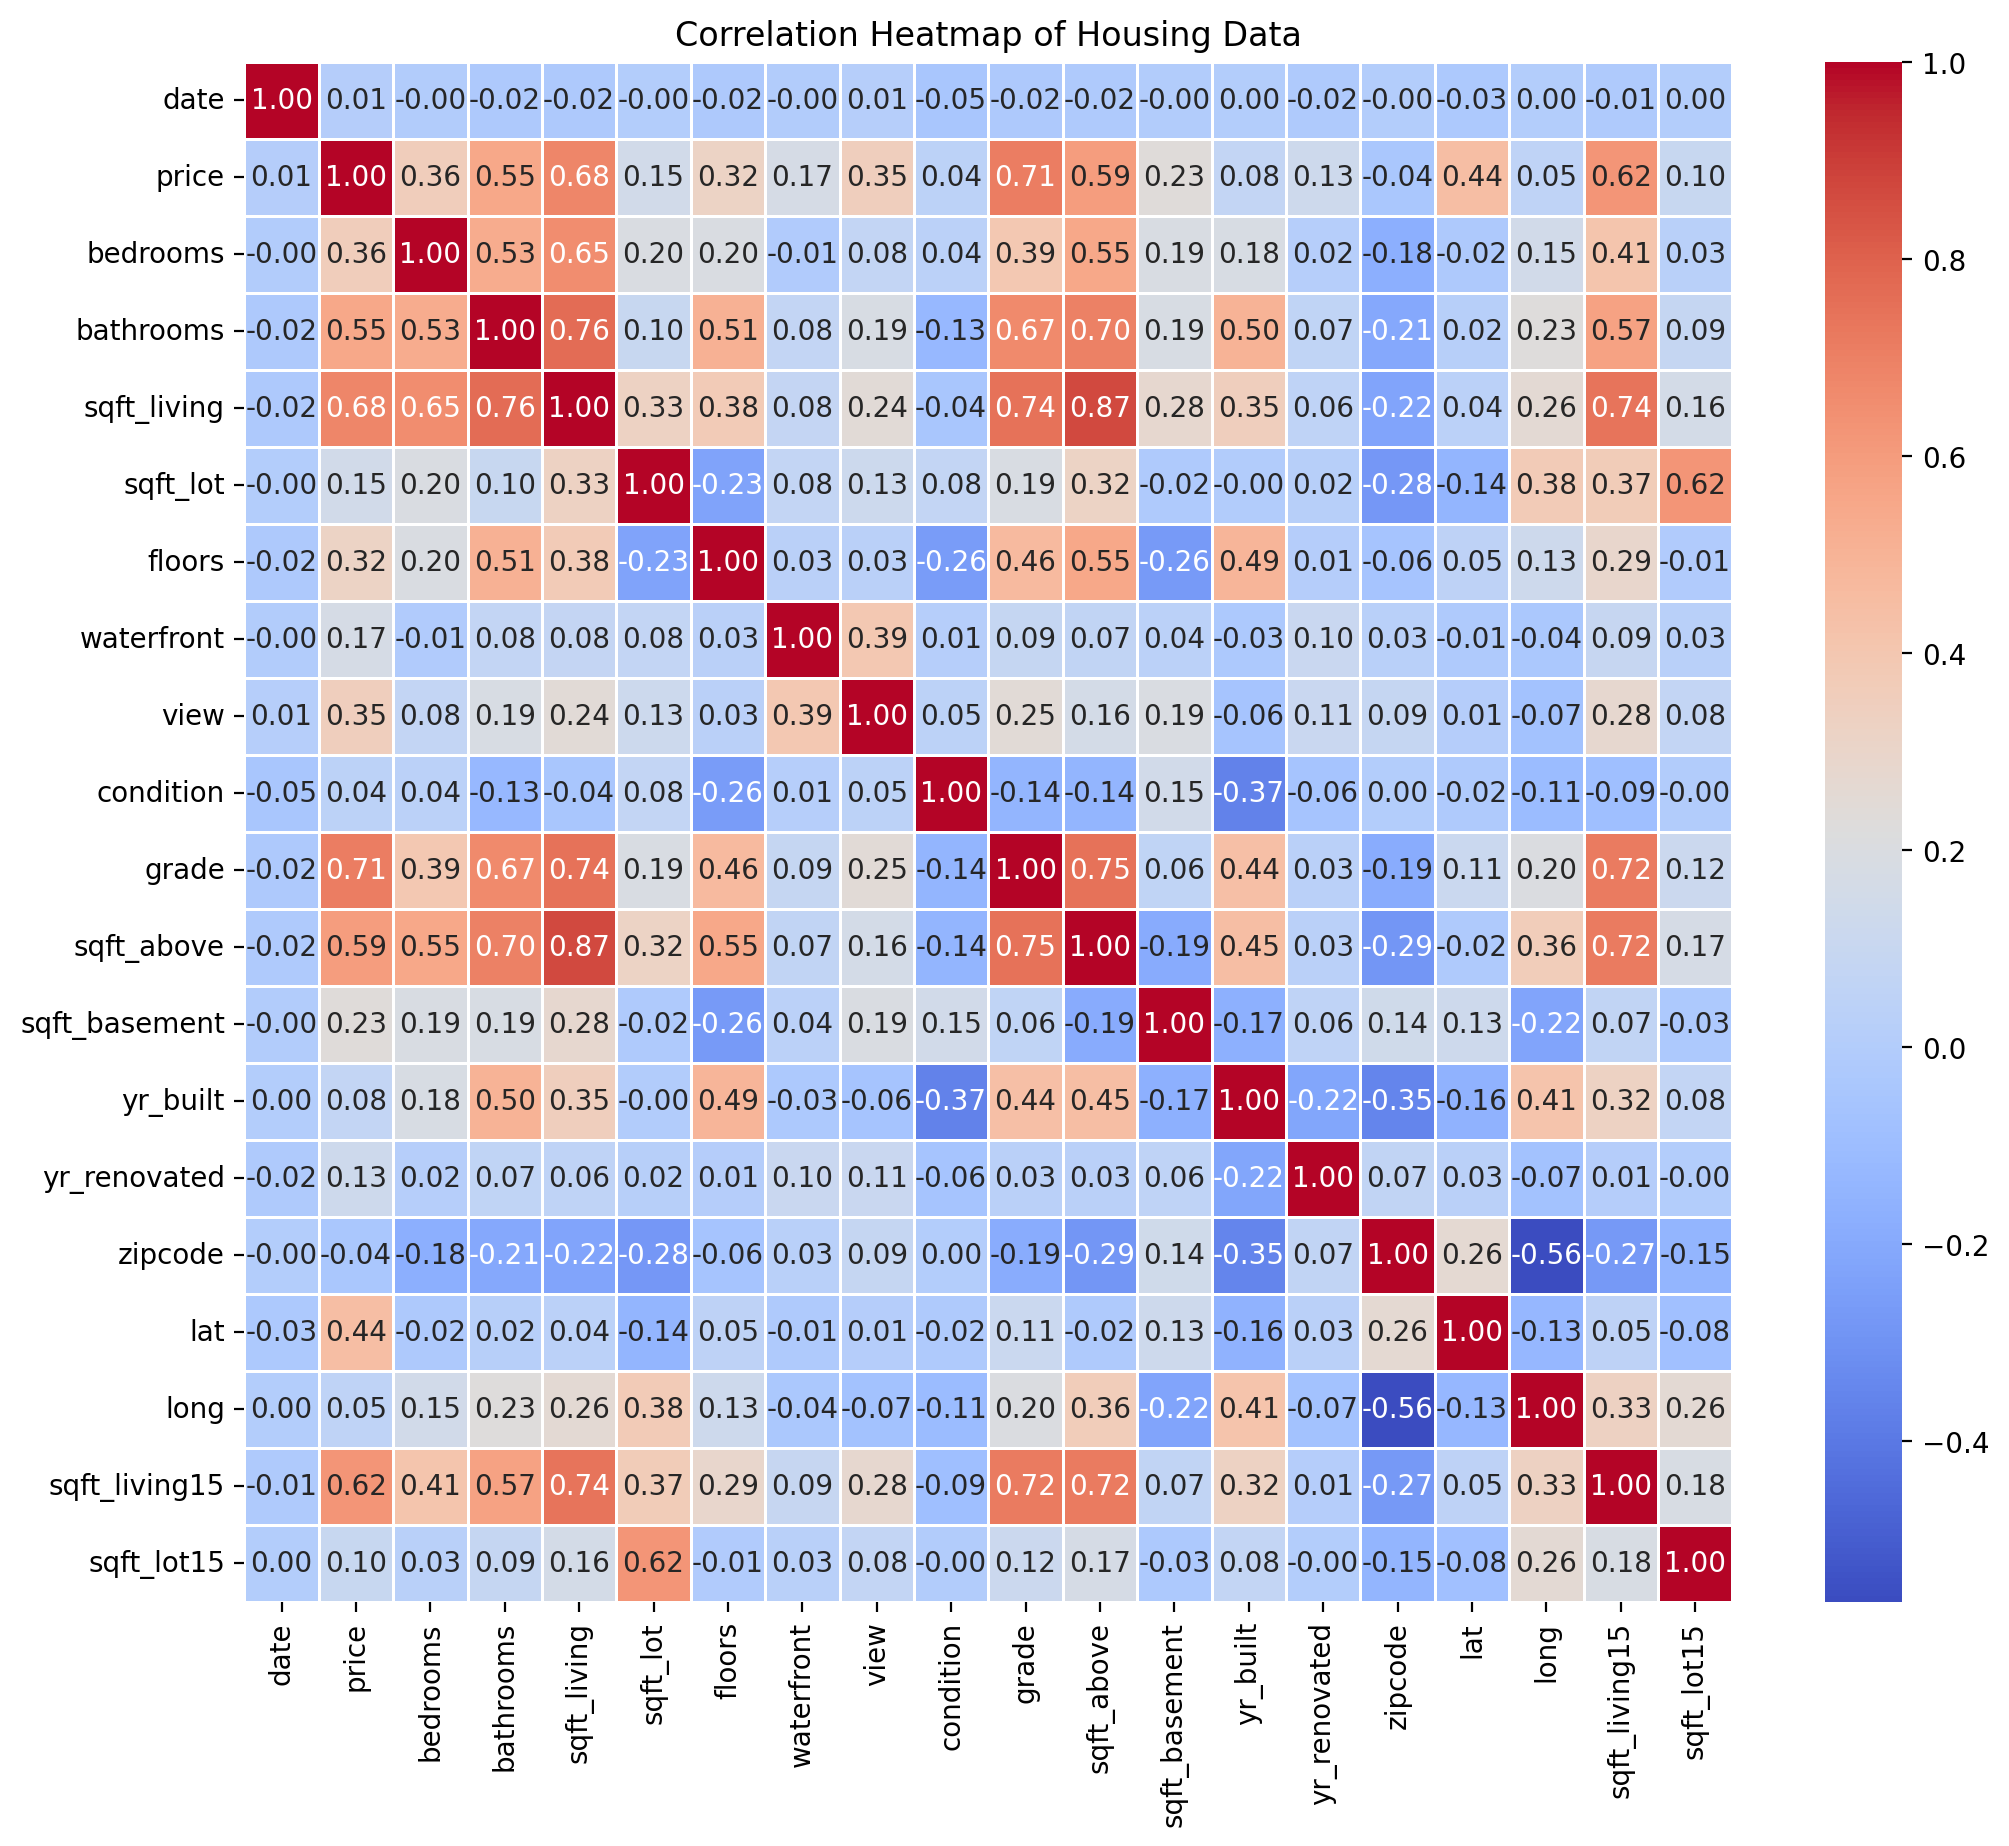

In [34]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Housing Data")
plt.show()

### 상관관계 분석
- 가격'과의 상위 상관관계는 grade(0.70), sqft_living(0.67), **sqft_living15(0.62)**, sqft_above(0.59)입니다.

## 훈련을 위한 데이터셋 생성

In [35]:
X = data.drop('price', axis = 1)
y = data['price']

random_state = 526

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = random_state)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12028, 19) (3007, 19)
(12028,) (3007,)


# 3. preprocessing

## scaling

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 변수선택

In [37]:
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

## PCA

In [38]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

## 4. 모델링

# Modeling
## stack_reg again

In [46]:
# Define models

gboost_best_params = {
    'learning_rate': 0.025670,
    'max_depth': 9,
    'max_features': 'log2',
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 256,
    'subsample': 0.742265
}

xgboost_best_params = {
    'colsample_bytree': 0.866721,
    'gamma': 0.043420,
    'learning_rate': 0.066143,
    'max_depth': 9,
    'n_estimators': 121,
    'subsample': 0.727895
}

lightgbm_best_params = {
    'colsample_bytree': 0.964985,
    'learning_rate': 0.043732,
    'max_depth': 9,
    'n_estimators': 346,
    'reg_alpha': 0.077336,
    'reg_lambda': 0.158151,
    'subsample': 0.850568,
}

rdforest_best_params = {
    'max_depth': 14,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 12,
    'n_estimators': 934,
}


gboost = GradientBoostingRegressor(**gboost_best_params, random_state=random_state)
xgboost = XGBRegressor(**xgboost_best_params, random_state=random_state)
lightgbm = LGBMRegressor(**lightgbm_best_params, random_state=random_state)
rdforest = RandomForestRegressor(**rdforest_best_params, random_state=random_state)

models = [
    ('gboost', gboost),
    ('xgboost', xgboost),
    ('lightgbm', lightgbm),
    ('rdforest', rdforest)
]

model = StackingRegressor(models, final_estimator = lightgbm)
model.fit(X_train, y_train)

#기존 코드
# y_pred = model.predict(X_train)
#print(np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))


# 수정된 코드: X_test에 대한 예측 수행
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2288
[LightGBM] [Info] Number of data points in the train set: 9622, number of used features: 19
[LightGBM] [Info] Start training from score 13.044961
[LightGBM] [Warning] No further split

## lightgbm
### RandomizedSearchCV

In [47]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 30),
    'subsample': uniform(0.6, 0.4),  # 0.6부터 1.0까지의 값 중에서 랜덤 샘플링
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6부터 1.0까지의 값 중에서 랜덤 샘플링
    'reg_alpha': uniform(0, 0.2),
    'reg_lambda': uniform(0, 0.2)
}

lightgbm = LGBMRegressor(random_state=random_state)
model = RandomizedSearchCV(estimator = lightgbm,
                          param_distributions = param_dist,
                          cv = 5,
                          scoring = 'neg_mean_squared_error',
                          n_jobs = -1,
                          random_state = random_state)
model.fit(X_train, y_train)
best_model = model.best_estimator_

y_pred = best_model.predict(X_test)

print(np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
109503.36307035982


## 5. Make Submission

제출 결과를 만들겠습니다

In [48]:
def preprocessing(data):
    data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

    skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

    for c in skew_columns:
        data[c] = np.log1p(data[c].values)

    # data = scaler.transform(data)
    # data = selector.transform(data)

    # data = pca.transform(data)

    return data

In [49]:
submission = pd.read_csv(sub_file_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [50]:
test = pd.read_csv(sub_data_path, index_col = 'id')
test.head()



date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                           
15035  20141209T000000         3       2.25         2570      7242     2.0   
15036  20141209T000000         4       3.00         1960      5000     1.0   
15037  20140512T000000         4       4.50         5420    101930     1.0   
15038  20150415T000000         3       1.00         1780      7470     1.0   
15039  20150312T000000         3       2.50         1890      6560     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
id                                                                     
15035           0     0          3      7        2170            400   
15036           0     0          5      7        1050            910   
15037           0     0          3     11        3890           1530   
15038           0     0          3      7        1050            730   
15039           0     0          3      7        1890              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
id                                                                        
15035      1951          1991    98125  47.7210 -122.319           1690   
15036      1965             0    98136  47.5208 -122.393           1360   
15037      2001             0    98053  47.6561 -122.005           4760   
15038      1960             0    98146  47.5123 -122.337           1780   
15039      2003             0    98038  47.3684 -122.031           2390   

       sqft_lot15  
id                 
15035        7639  
15036        5000  
15037      101930  
15038        8113  
15039        7570

In [51]:
test = preprocessing(test)


test_df = pd.DataFrame(test)  # selected_features에는 열 이름이 포함되어야 합니다.
print(test_df.head())

         date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  \
id                                                                   
15035  201412  1.386294       2.25     7.852050   8.887791     2.0   
15036  201412  1.609438       3.00     7.581210   8.517393     1.0   
15037  201405  1.609438       4.50     8.598036  11.532051     1.0   
15038  201504  1.386294       1.00     7.484930   8.918784     1.0   
15039  201503  1.386294       2.50     7.544861   8.788898     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
id                                                                     
15035           0     0          3      7    7.682943       5.993961   
15036           0     0          5      7    6.957497       6.814543   
15037           0     0          3     11    8.266421       7.333676   
15038           0     0          3      7    6.957497       6.594413   
15039           0     0          3      7    7.544861       0.000000   

    

In [52]:
pred = best_model.predict(test)
pred = np.expm1(pred)
print(pred, len(pred))

[ 496348.53819237  491253.23631292 1390758.45714464 ...  473976.47159646
  327557.2123566   446843.1822517 ] 6468


In [53]:
submission['price'] = pred
submission.head()

id         price
0  15035  4.963485e+05
1  15036  4.912532e+05
2  15037  1.390758e+06
3  15038  3.105640e+05
4  15039  3.285901e+05

In [55]:
submission['price'] = pred
submission.to_csv('/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/submission.csv', index=False)